In [1]:
import pandas as pd

In [2]:
ing_cat_rdb = pd.read_csv('Data/RecipeDB_ingredient_flavor.csv')
ing_cat_rdb = ing_cat_rdb[['ingredient', 'Dietrx_Category']]
ing_cat_rdb

,ingredient,Dietrx_Category
0,salt,Additive
1,onion,Vegetable
2,butter,Dairy
3,water,Additive
4,garlic clove,Herb
...,...,...
19014,zucchini squash,Vegetable
19015,zucchini summer squash,Fruit
19016,zucchini tomato sauce,Condiment
19017,zwieback breadcrumb,Bakery


In [3]:
ner = pd.read_csv('Data/RecipeDB2_NER_post.csv')

In [4]:
# Calculate frequency of each ingredient with their unique ing_id
unique_ingredients = ner.groupby(['ingredient', 'ing_id']).size().reset_index(name='frequency')

# Sort the DataFrame by frequency in descending order
ing_category_rdb2 = unique_ingredients.sort_values(by='frequency', ascending=False)

ing_category_rdb2


,ingredient,ing_id,frequency
27867,salt,1.0,53234
13365,garlic,2.0,42715
22440,onion,3.0,37160
33941,water,4.0,27799
5975,butter,5.0,26624
...,...,...,...
14394,grainy dijon mustard,23762.0,1
14393,grainy brown mustard,17378.0,1
14392,grainy bread,31766.0,1
14389,grain wheat flour,25260.0,1


In [5]:
# shows common ingredients for which category is available
pd.merge(ing_cat_rdb, ing_category_rdb2, on='ingredient')


,ingredient,Dietrx_Category,ing_id,frequency
0,salt,Additive,1.0,53234
1,onion,Vegetable,3.0,37160
2,butter,Dairy,5.0,26624
3,water,Additive,4.0,27799
4,garlic clove,Herb,948.0,108
...,...,...,...,...
10654,zucchini raita,Vegetable,23918.0,1
10655,zucchini squash,Vegetable,9687.0,2
10656,zucchini summer squash,Fruit,17205.0,1
10657,zucchini tomato sauce,Condiment,21923.0,1


In [6]:
ing_cat_rdb2 = pd.merge(ing_cat_rdb, ing_category_rdb2, on='ingredient', how='right')
ing_cat_rdb2

,ingredient,Dietrx_Category,ing_id,frequency
0,salt,Additive,1.0,53234
1,onion,Vegetable,3.0,37160
2,butter,Dairy,5.0,26624
3,water,Additive,4.0,27799
4,garlic clove,Herb,948.0,108
...,...,...,...,...
35469,gram basa fish,NaN,29309.0,1
35470,gralic,NaN,24206.0,1
35471,grainy yellow mustard,NaN,33265.0,1
35472,grainy french mustard,NaN,27163.0,1


In [7]:
x = ing_cat_rdb2[ing_cat_rdb2['Dietrx_Category'].isna()]
x

,ingredient,Dietrx_Category,ing_id,frequency
10659,allpurpose flour,NaN,23.0,8844
10660,baking powder,NaN,36.0,5651
10661,baking soda,NaN,71.0,3107
10662,red chilli powder,NaN,80.0,2817
10663,green chilli,NaN,92.0,2469
...,...,...,...,...
35469,gram basa fish,NaN,29309.0,1
35470,gralic,NaN,24206.0,1
35471,grainy yellow mustard,NaN,33265.0,1
35472,grainy french mustard,NaN,27163.0,1


In [8]:
print('Minm frequency:', x['frequency'].min())
print('Maxm frequency:', x['frequency'].max())
print('Average frequency:', x['frequency'].mean())

Minm frequency: 1
Maxm frequency: 8844
Average frequency: 5.501873866612936


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming complete_ingredient_data is your DataFrame

# Step 1: Prepare the Data
# Remove rows where category is NaN for training
train_data = ing_cat_rdb2[ing_cat_rdb2['Dietrx_Category'].notna()]
test_data = ing_cat_rdb2[ing_cat_rdb2['Dietrx_Category'].isna()]

# Step 2: Feature Extraction
# Use TF-IDF vectorization for the ingredient names
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['ingredient'])
y = train_data['Dietrx_Category']

# Step 3: Split the Data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

# Step 5: Create a Random Forest model
model = RandomForestClassifier(random_state=42)

# Step 6: Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Step 7: Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Step 8: Best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search.best_score_))

# Step 9: Use the best estimator to make predictions
best_model = grid_search.best_estimator_

# Step 10: Make Predictions on the validation set
val_predictions = best_model.predict(X_val)

# Step 11: Calculate accuracy and generate a classification report
accuracy = accuracy_score(y_val, val_predictions)
print(f'Accuracy after tuning: {accuracy:.2f}')

# Optional: Print the classification report for more insights
print(classification_report(y_val, val_predictions))

# Step 12: Make Predictions on the test data and assign predictions back
X_test = vectorizer.transform(test_data['ingredient'])
predictions = best_model.predict(X_test)
ing_cat_rdb2.loc[ing_cat_rdb2['Dietrx_Category'].isna(), 'Dietrx_Category'] = predictions

# Display the updated DataFrame
print(ing_cat_rdb2)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/home/mansig/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.74
Accuracy after tuning: 0.75
                      precision    recall  f1-score   support

            Additive       0.65      0.54      0.59       151
       Additive-Salt       1.00      0.40      0.57         5
      Additive-Sugar       0.60      0.60      0.60         5
    Additive-Vinegar       1.00      0.33      0.50         6
              Bakery       0.84      0.80      0.82       137
               Berry       0.00      0.00      0.00         1
            Beverage       0.52      0.72      0.60        43
Beverage Caffeinated       0.50      1.00      0.67         2
  Beverage-Alcoholic       0.86      0.74      0.79       110
              Cereal       0.85      0.89      0.87       140
           Condiment       0.74      0.64      0.68        85
               Dairy       0.90      0.92      0.91       127
 

/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  ingredient Dietrx_Category   ing_id  frequency
0                       salt        Additive      1.0      53234
1                      onion       Vegetable      3.0      37160
2                     butter           Dairy      5.0      26624
3                      water        Additive      4.0      27799
4               garlic clove            Herb    948.0        108
...                      ...             ...      ...        ...
35469         gram basa fish            Fish  29309.0          1
35470                 gralic            Dish  24206.0          1
35471  grainy yellow mustard       Condiment  33265.0          1
35472  grainy french mustard       Condiment  27163.0          1
35473          � pasta sauce        Additive  30273.0          1

[35474 rows x 4 columns]


In [23]:
ing_cat_rdb2.to_csv('Data/Ingredient_Category.csv', index=False)

In [27]:
ing_cat_rdb2['Dietrx_Category'].nunique()

35

In [28]:
ing_cat_rdb2['Dietrx_Category'].unique()

array(['Additive', 'Vegetable', 'Dairy', 'Herb', 'Plant Derivative',
       'Meat', 'Spice', 'Cereal', 'Beverage', 'Condiment',
       'Vegetable Tuber', 'Fruit', 'Fungi', 'Vegetable Fruit', 'Plant',
       'Maize', 'Beverage-Alcoholic', 'Nuts and Seeds', 'Legume',
       'Essential Oil', 'Seafood', 'Additive-Salt', 'Bakery', 'Gourd',
       'Additive-Vinegar', 'Seed', 'Dish', 'Fish', 'Additive-Sugar',
       'Flower', 'Beverage Caffeinated', 'Berry', 'Fungus', 'dish',
       'Additive-Yeast'], dtype=object)

In [ ]:
# Get the value counts of the 'Dietrx_Category' column
category_counts = ing_cat_rdb2['Dietrx_Category'].value_counts()

# Convert the series to a DataFrame
category_counts_df = category_counts.reset_index()

# Rename the columns for clarity
category_counts_df.columns = ['Dietrx_Category', 'Count']

# Display the DataFrame
print(category_counts_df)

category_counts_df.to_csv('Data/Unique_Category_Count.csv', index=False)


# Comparison of Models

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Prepare the data
# Remove rows where category is NaN for training
train_data = ing_cat_rdb2[ing_cat_rdb2['Dietrx_Category'].notna()]
test_data = ing_cat_rdb2[ing_cat_rdb2['Dietrx_Category'].isna()]

# Use TF-IDF vectorization for the ingredient names
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['ingredient'])
y = train_data['Dietrx_Category']

# Split the Data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Classifier": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Store the results
results = []

# Iterate through the models and evaluate them
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    val_predictions = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, val_predictions)
    report = classification_report(y_val, val_predictions, output_dict=True)
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1 Score': report['weighted avg']['f1-score']
    })

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Display the results
print(results_df.sort_values(by='Accuracy', ascending=False))


/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mansig/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       Model  Accuracy  Precision    Recall  F1 Score
1              Random Forest  0.891191   0.893817  0.891191  0.891639
5              Decision Tree  0.871882   0.874412  0.871882  0.872527
3  Support Vector Classifier  0.853136   0.860556  0.853136  0.854818
0        Logistic Regression  0.820437   0.831737  0.820437  0.821667
2          Gradient Boosting  0.807470   0.830534  0.807470  0.810930
4                Naive Bayes  0.701903   0.718683  0.701903  0.677272
6        K-Nearest Neighbors  0.677801   0.718345  0.677801  0.689222


In [25]:
import joblib

# Assuming Random Forest is the model with the best accuracy
best_model = models["Random Forest"]

# Save the model to a file
joblib.dump(best_model, 'random_forest_model.pkl')

print("Random Forest model saved as 'random_forest_model.pkl'")


Random Forest model saved as 'random_forest_model.pkl'


# Ingredient Frequency Category Analysis

In [2]:
ing_cat = pd.read_csv('Data/Ingredient_Category.csv')

In [3]:
ing_cat

,ingredient,Dietrx_Category,ing_id,frequency
0,salt,Additive,1.0,53234
1,onion,Vegetable,3.0,37160
2,butter,Dairy,5.0,26624
3,water,Additive,4.0,27799
4,garlic clove,Herb,948.0,108
...,...,...,...,...
35469,gram basa fish,Fish,29309.0,1
35470,gralic,Dish,24206.0,1
35471,grainy yellow mustard,Condiment,33265.0,1
35472,grainy french mustard,Condiment,27163.0,1


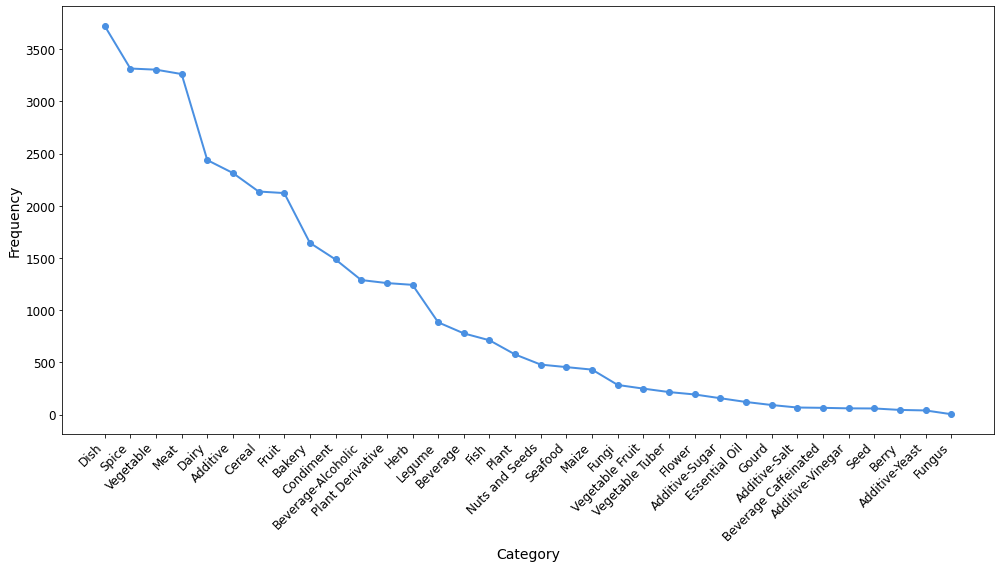

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of unique ingredients per category

ingredient_counts = ing_cat[ing_cat['Dietrx_Category'] != 'dish'].groupby('Dietrx_Category')['ingredient'].nunique().sort_values(ascending=False)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create line plot for category ingredient counts
plt.plot(ingredient_counts.index, ingredient_counts.values, color='#4a90e2', marker='o', linestyle='-', linewidth=2, markersize=6)

plt.xlabel('Category', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)  # Horizontal grid lines for readability
plt.tight_layout()
# plt.savefig('Plots/Ingredient_Category.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of unique ingredients per category
ingredient_counts = ing_cat[ing_cat['Dietrx_Category'] != 'dish'].groupby('Dietrx_Category')['ingredient'].nunique().sort_values(ascending=False)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the stick plot (lollipop plot)
plt.vlines(x=ingredient_counts.index, ymin=0, ymax=ingredient_counts.values, color='#4a90e2', linewidth=2)
plt.plot(ingredient_counts.index, ingredient_counts.values, 'o', color='#4a90e2', markersize=6)

# Labels and layout adjustments
plt.xlabel('Category', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Plots/Ingredient_Category.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1400x800 with 1 Axes>